# Introduction to FGC: Comparing Forest-Guided Clustering and Feature Importance

📚 In this notebook, we compare the **Forest-Guided Clustering (FGC)** algorithm to standard explainability methods—namely, **Permutation Feature Importance** and the built-in **Feature Importance Scores from Random Forests**. The goal is to highlight how FGC can uncover meaningful structure in the data, especially in the presence of feature correlations and complex interactions.

📦 **Installation:** To get started, you need to install the `fgclustering` package. Please follow the instructions on the [official installation guide](https://forest-guided-clustering.readthedocs.io/en/latest/_getting_started/installation.html).

🚧 **Note:** For a general introduction to FGC, please refer to our [Introduction Notebook](https://forest-guided-clustering.readthedocs.io/en/latest/_tutorials/introduction_to_FGC_use_cases.html).

**Imports:**

In [1]:
# Load the required packages

import pandas as pd

from palmerpenguins import load_penguins

from fgclustering import (
    forest_guided_clustering, 
    forest_guided_feature_importance, 
    plot_forest_guided_feature_importance, 
    plot_forest_guided_decision_paths,
    DistanceRandomForestProximity,
    ClusteringKMedoids,
)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from utils.utils import * 

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/fgc/lib/python3.12/site-packages/palmerpenguins/penguins.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## The Palmer Penguins Dataset: Data Preprocessing and Model Training

In this notebook, we explore the **Palmer Penguins dataset**, which includes information on three penguin species — **Adelie**, **Chinstrap**, and **Gentoo** — observed in the Palmer Archipelago near Palmer Station, Antarctica. The dataset consists of **344 penguins**, each described by a range of attributes, including body measurements, clutch observations, and blood isotope ratios. Our objective is to **predict the species** of a penguin based on its characteristics and to **uncover the key differences** among the three species.

<p align="center">
  <img src="https://raw.githubusercontent.com/HelmholtzAI-Consultants-Munich/fg-clustering/main/docs/source/_figures/penguins.png" width="500" />
</p>

<sub>Image source: [palmerpenguins by Allison Horst](https://allisonhorst.github.io/palmerpenguins/)</sub>


In [2]:
# Load the data
data_penguins = load_penguins()

# Inspect the data
data_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Before training our model, we need to preprocess the dataset. First, we handle missing values by applying a common strategy, i.e. **removing any rows that contain missing data**. This allows us to proceed with a clean subset of the dataset for analysis. Next, we address the **categorical features**, which need to be converted into a numerical format suitable for machine learning algorithms. In this example, we use **dummy encoding (one-hot encoding)**, which transforms each categorical variable into a set of binary columns (one for each category level).

In [3]:
# Remove the instances with missing values and check how many we are left with
print(f"Before omiting the missing values the dataset has {data_penguins.shape[0]} instances")
data_penguins.dropna(inplace=True)
print(f"After omiting the missing values the dataset has {data_penguins.shape[0]} instances")

# preprocess categorical features such that they can be used for the RF model
data_penguins_encoded = pd.get_dummies(data_penguins, columns=['island', 'sex'], prefix=['island', 'sex'], drop_first=True)

Before omiting the missing values the dataset has 344 instances
After omiting the missing values the dataset has 333 instances


Now that our data is prepared, we're ready to **train the Random Forest model**. We start by defining a small grid of hyperparameters for demonstration purposes, keeping it simple to focus on the overall workflow. Then, we instantiate a `RandomForestClassifier` and use `GridSearchCV` with 5-fold cross-validation to tune the model based on the predefined parameter grid. The best-performing model is stored in the `best_estimator_` attribute of the `GridSearchCV` object.

In [4]:
# Grid of hyperparameters 
hyper_grid_classifier = {'n_estimators': [100, 1000], 
            'max_depth': [2, 5, 10], 
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt','log2']
}

In [5]:
# A Random Forest instance from sklearn requires a separate input of feature matrix and target values. 
# Hence, we will first separate the target and feature columns. 
X_penguins = data_penguins_encoded.loc[:, data_penguins_encoded.columns != 'species']
y_penguins = data_penguins_encoded.species

# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the test set score
classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42, n_jobs=1)

# Define a grid search with 5-fold CV and fit 
gridsearch_classifier = GridSearchCV(classifier, hyper_grid_classifier, cv=5, verbose=1)
gridsearch_classifier.fit(X_penguins, y_penguins)

# Take the best estimator
rf = gridsearch_classifier.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [6]:
# Check the results
print('out-of-bag accuracy of prediction model:')
print(rf.oob_score_)

out-of-bag accuracy of prediction model:
0.993993993993994


Great! You've successfully trained a Random Forest model—and it achieved an impressive **out-of-bag accuracy of 99%**. 🎉

But is that the end of the story? What if we want to **go beyond accuracy** and actually understand how the model makes its predictions? It's time to dive into the **explainability** and uncover the insights hidden within the forest. 🌲🕵️‍♂️

## Interpreting Random Forest Models with Feature Importance

Understanding which features drive the predictions of a model is central to explainability. Two widely used feature importance methods are **Permutation Feature Importance** and **Random Forest Feature Importance** (Mean Decrease in Impurity). In this section, we explore how both methods behave — especially in the presence of correlated features — using our Penguin dataset.


### Permutation Feature Importance

**Permutation Feature Importance** measures the **change in model performance** when the values of a single feature are randomly shuffled. This breaks the relationship between that feature and the target, helping estimate how crucial the feature is to the model’s predictive performance. A large drop in accuracy indicates high importance. This method is **model-agnostic**, making it a popular choice across different machine learning algorithms. However, one major drawback is its **sensitivity to feature correlation**. When features are highly correlated, the importance of individual features may be underestimated, as the model can rely on correlated alternatives for its predictions.

Let’s apply this method to the trained Random Forest classifier and see how it performs on the penguin data.

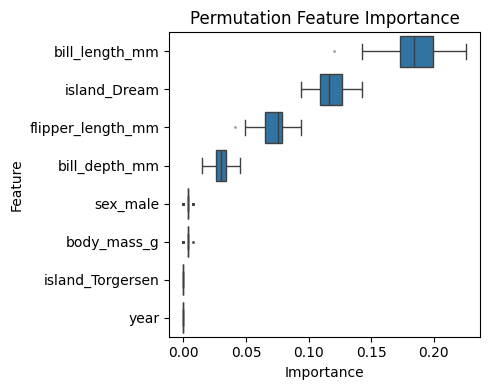

In [7]:
result = permutation_importance(rf, X_penguins, y_penguins, n_repeats=50, max_samples = 0.8, random_state=42)
plot_permutation_feature_importance(result=result, data=X_penguins, title="Permutation Feature Importance")

### Random Forest Feature Importance (Mean Decrease in Impurity)

Random Forests also offer a built-in method for estimating feature importance, based on the **mean decrease in impurity (MDI)**. During training, each time a feature is used to split a node, the impurity of the resulting children is compared to that of the parent node. The total impurity decrease from all such splits is accumulated for each feature and then averaged across all trees. This method is **efficient and fast**, as it is computed during model training. It is less sensitive to correlated features than Permutation Importance, but still not completely immune. Moreover, it is known to have a **bias towards features with many unique values** or continuous variables.

Let’s plot the feature importance based on MDI and compare it with the Permutation Importance:

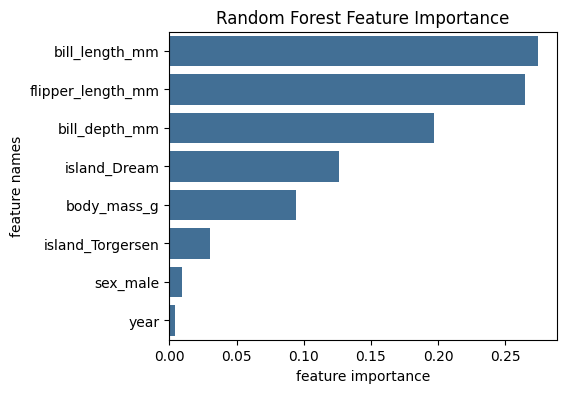

In [8]:
plot_impurity_feature_importance(rf.feature_importances_, names=X_penguins.columns, title="Random Forest Feature Importance")

📌 **Observation:** The MDI-based Feature Importance identifies more features as highly important compared to the Permutation Importance. In particular, features like `flipper_length` and `body_mass`, which are highly correlated, show artificially lower scores in the permutation method. This is because the model can "fall back" on correlated features when one is permuted, underestimating their true joint relevance. The MDI method, on the other hand, distributes the importance more proportionally across correlated features.

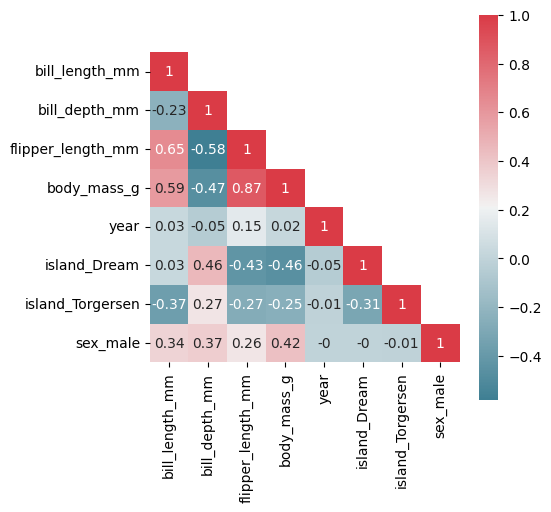

In [9]:
plot_correlation_matrix(X_penguins)

❗ **Limitations and Motivation for FGC:** While both methods provide a ranking of features, they share an important limitation: **they do not reveal how features interact with each other** or how different subgroups (e.g., classes) rely on different subsets of features. Neither method provides **class-specific interpretations**, nor do they reveal the **decision logic** embedded within the forest. This is where **Forest-Guided Clustering (FGC)** comes in, a Random Forest-specific explainability method that utilizes the internal structure of the forest to uncover how subgroups of samples traverse similar paths in the trees.

Let’s explore this method in the next section and see how it can offer a deeper understanding of your model’s behavior.

## Interpreting Random Forest Models with Forest-Guided Clustering

Now that we’ve explored traditional feature importance methods, it’s time to dive deeper into the model’s internal logic using **Forest-Guided Clustering (FGC)**. FGC allows us to go beyond global feature rankings by uncovering **how the Random Forest model segments the input space** and which features drive decisions in each segment. In this section, we'll apply FGC to the previously trained Random Forest classifier and compare the resulting feature importance scores to those obtained from Permutation and MDI-based methods.

### Compute the Forest-Guided Clusters

FGC uses the **K-Medoids clustering algorithm**, which requires a predefined number of clusters `k`. To simplify this example (and speed up computation), we’ll set `k` equal to the number of species in the penguin dataset. However, FGC can also **automatically optimize** the number of clusters by balancing **model fit (low bias)** and **model stability (low variance)** using a scoring function based on predictive separation and Jaccard stability.

In [10]:
# compute forest guided clusters
fgc = forest_guided_clustering(
    k=3,
    estimator=rf, 
    X=X_penguins, 
    y=y_penguins, 
    clustering_distance_metric=DistanceRandomForestProximity(), 
    clustering_strategy=ClusteringKMedoids(method="fasterpam", max_iter=200)
)

Using a sample size of 80.0 % of the input data for Jaccard Index computation.
Using range k = (3, 3) to optimize k.


Optimizing k: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                   Cluster_JI
 3 0.018666    True    0.999 {1: 0.999, 2: 1.0, 3: 0.999}


One key advantage of FGC is that clustering is performed in **sample space**, not feature space, using proximities derived from Random Forest decision paths. This means we are no longer constrained by the encoded feature set used for training. We can now reintroduce the original **categorical features** (e.g., `sex` and `island`) into the feature importance analysis using their raw, interpretable values. This results in more intuitive explanations and richer insights.

In [11]:
# covert dummy encoded features back to category 
data_penguins['island'] = data_penguins['island'].astype('category')
data_penguins['sex'] = data_penguins['sex'].astype('category')

feature_importance = forest_guided_feature_importance(
    X=data_penguins, 
    y="species", 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
    feature_importance_distance_metric="jensenshannon",
)

100%|██████████| 7/7 [00:00<00:00, 633.18it/s]


FGC provides two main visualization tools to support interpretation: **Global and Local Feature Importance Plots** and **Cluster Decision Path Visualization**. Together, these tools allow us to explore both **what** features matter and **how** they drive decisions for different subgroups in the data. Let’s apply FGC and examine the results!

### Evaluate Feature Importance

Forest-Guided Clustering provides both **global** and **local feature importance** to help understand how features distinguish between different clusters.

* **Local feature importance** measures how much a feature’s distribution in one cluster deviates from a reference distribution—either the full dataset (background) or the average across all clusters. This is quantified using either the **Wasserstein distance** (if mainly continuous features) or the **Jensen-Shannon distance** (if mainly categorical features).
* **Global feature importance** is the average of local importances across all clusters, highlighting features that consistently differ between subpopulations.

High global importance means that a feature separates clusters well across the entire dataset, while low values indicate that a feature has similar distributions across clusters and does not contribute much to the segmentation.

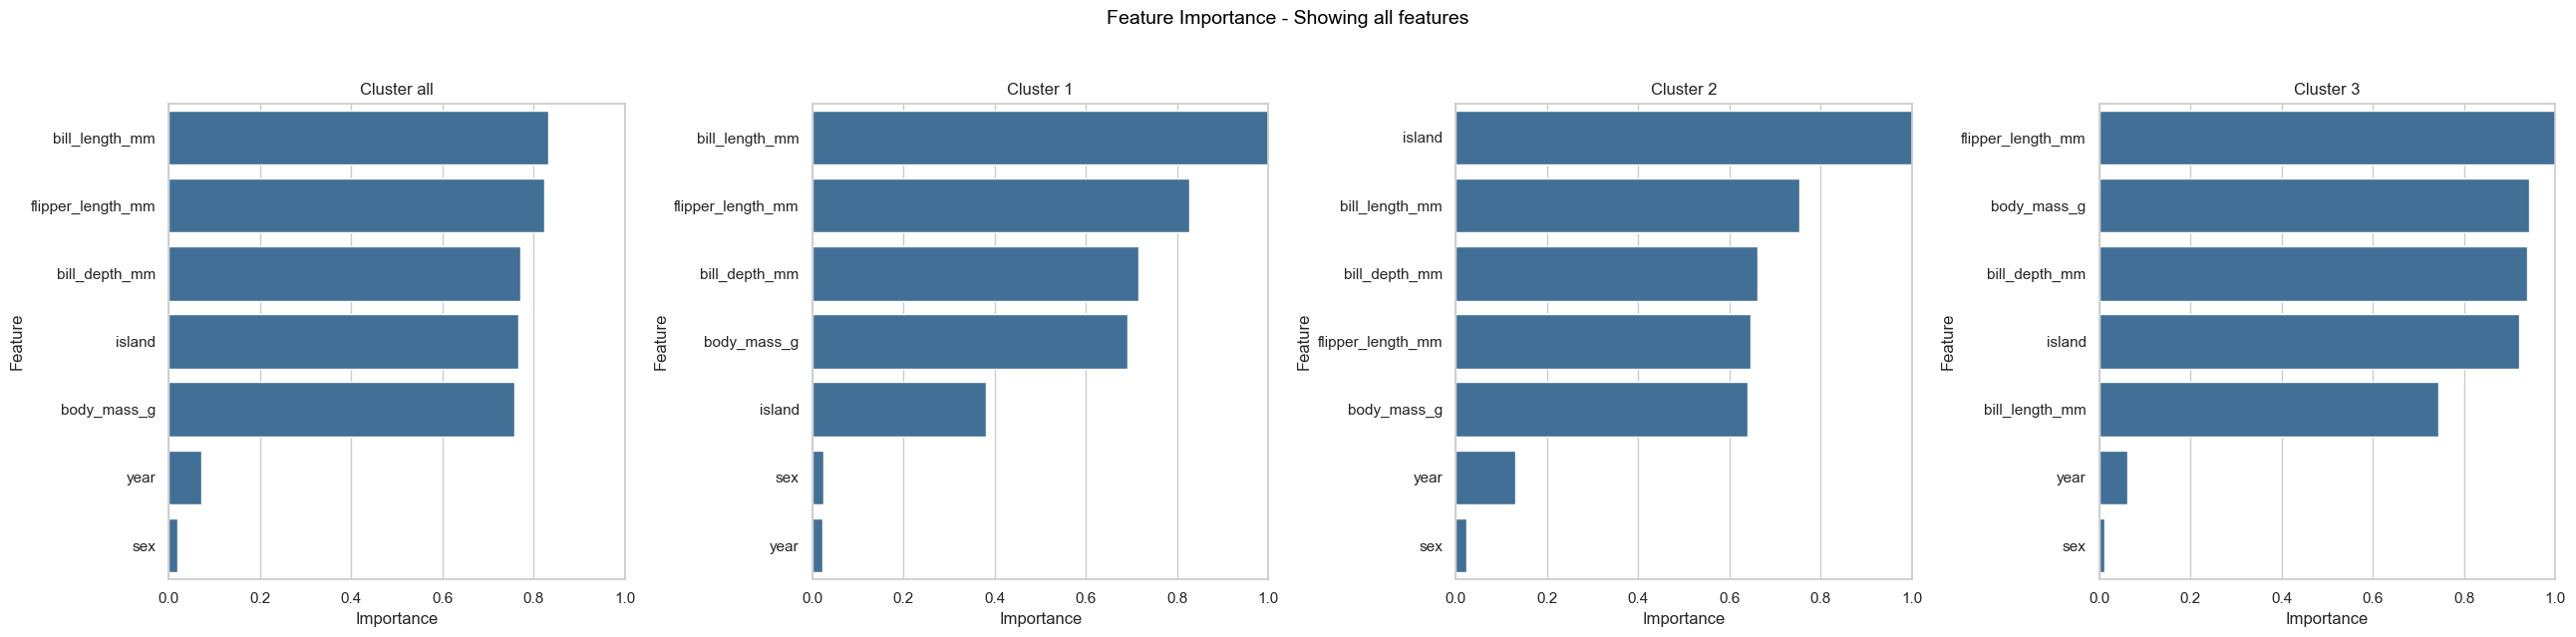

In [12]:
plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global
)

From the resulting plots, we see that the global importance aligns closely with the standard Random Forest Feature Importance. However, local importance adds nuance, for instance, *bill length* plays a stronger role in differentiating clusters 1 and 2 than it does for cluster 3. This level of detail helps uncover class-specific patterns and feature interactions that are not captured by standard feature importance methods.

### Visualizing the Decision Paths of the Random Forest Model

Forest-Guided Clustering offers a unique way to visualize the internal decision logic of a Random Forest model. It does so through two complementary visualizations: a **heatmap summary** and **feature-wise distribution plots**.

* The **heatmap** gives a high-level overview of how clusters relate to the target variable and highlights **feature enrichment or depletion** within each cluster. It helps identify which target values dominate each cluster and flags samples that fall into an unexpected cluster, potentially due to outliers, mislabeling, or anomalies.

* The **distribution plots** present the same information on a per-feature basis, but without standardization. This allows you to inspect the **actual scale and spread** of feature values within each cluster, revealing patterns such as skewness or within-cluster variance.

You can control which features are included in the plots by adjusting the `top_n` parameter, which displays the *n* features with the highest global importance. Together, these plots reveal how the Random Forest segments the input space, giving a hint on the **implicit decision rules** that guide its predictions.


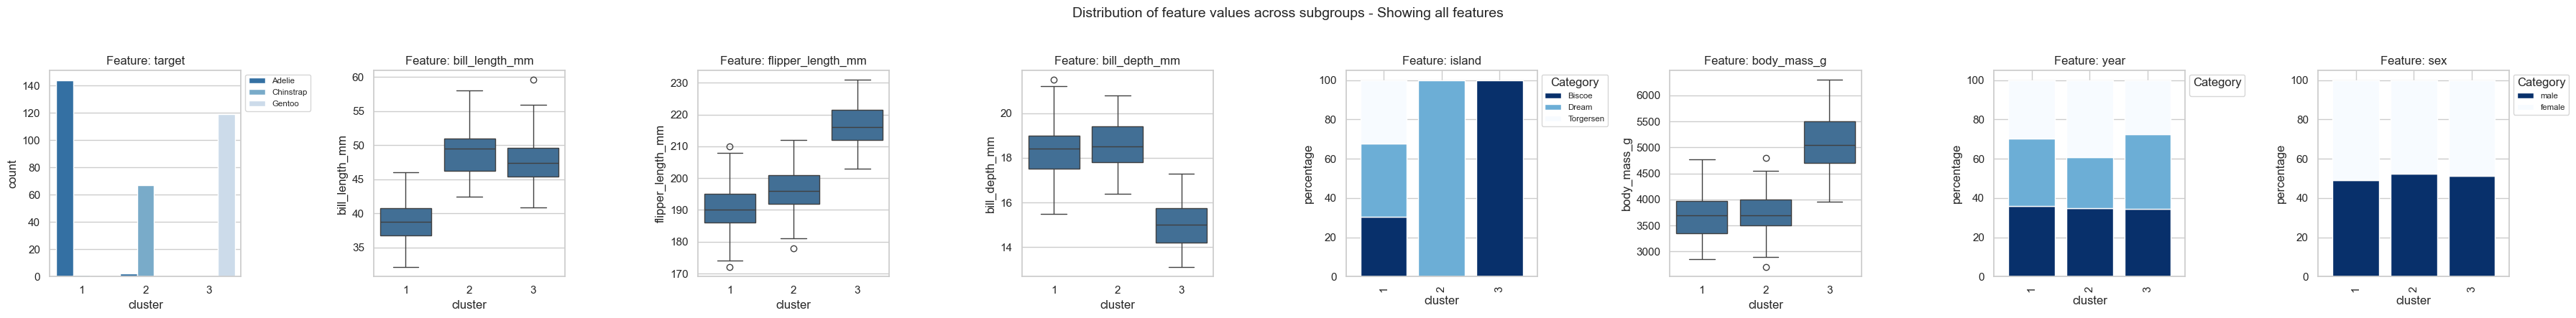

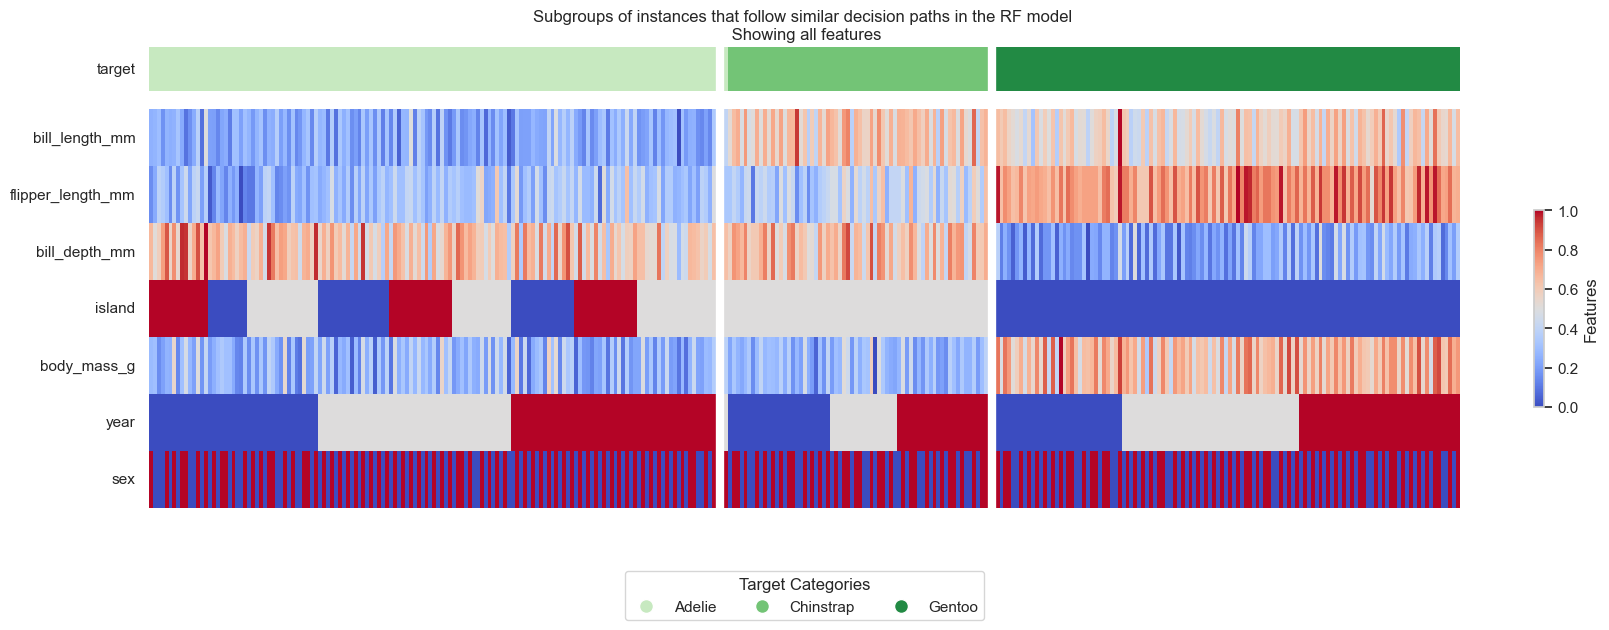

In [13]:
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    num_cols=8
)

## Conclusion: Comparing Forest-Guided Clustering with Traditional Feature Importance Methods

🏁  In this notebook, we explored and compared three different methods for interpreting Random Forest models: Permutation Feature Importance (PFI), Random Forest Feature Importance (MDI), and Forest-Guided Clustering (FGC). Each method offers unique strengths—but also comes with limitations.

* **PFI** provides model-agnostic insights by measuring the drop in performance when individual features are shuffled. However, it is **highly sensitive to feature correlations**, often underestimating the importance of correlated features or producing unstable rankings.

* **MDI**, based on the mean decrease in impurity, is more stable and specific to Random Forests. It better handles feature correlations than PFI, but still provides a **global ranking only**, without insight into **local decision behavior or class-specific relevance**.

* **FGC**, in contrast, shifts the focus from isolated features to **groups of samples** that follow similar decision paths through the forest. It reveals **how the model organizes the data**, identifies **feature relevance per cluster (local importance)**, and provides **global explanations** by aggregating these differences. It also supports interpretable visualizations of decision patterns and uncovers **latent structure** in the data that other methods may miss.

Ultimately, FGC goes beyond simply ranking features—it provides **a rich and structured understanding of how the Random Forest model partitions the input space** and uses features in context. By combining FGC with traditional feature importance methods, practitioners can achieve both **breadth and depth** in model interpretation—bridging the gap between accuracy and explainability.
